# Linear models with CNN features

In [2]:
# Rather than importing everything manually, we'll make things easy
# and load them all in utils.py, and just import them from here
%matplotlib inline
import utils
import imp
imp.reload(utils)
from utils import *


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
Using TensorFlow backend.


## Introduction

We need to find a way to convert the imagenet predictions to a probability of being a vat or a dog, since that is what the Kaggle competition requires us to submit. We could use the imagenet hierarchy to download a list of all the imagenet catefories in each of the log and cat groups, and could then solve out problem in various ways, such as:

- Finding the largest probability that's either a cat or a dog, and using that label
- Averaging the probability of all the cat categories and comparing it to the average of all the dog categories.

But these approaches have some downsides:

- They require manual coding for something that we should be able to learn from the data
- They ignore information available in the predictions; for instance, if the models predicts that therer is a bone in the image, it's more likely to be a dog than a cat.

A very simple solution to both of these problems is to learn a linear model that is trained using the 1,000 predictions from the imagenet model for each image as input, and the dog/cat label as target.


In [3]:
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Linear models in Keras

It turns out that each of the `Dense()` layers is jus a _linear model_, followed by a simple ~activation~. We'll learn about the activation function later - first, let's review how linear models work.

A linear modes is (as I'm sure you know) simply a model where each row is calculated as _sum(row*weights)_, whre ~weights~ needs to be learnt from the data, and will be he same for every row. For example, let's create some data that we know is linearly related:

In [ ]:
x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

In [ ]:
x[:5]

In [ ]:
y[:5]

We can use keras to create a simple linear model (_Dense()_ - with no activation - in Keras) and optimize it using SGD to minimize mean squared error (_mse_):

In [ ]:
lm = Sequential([ Dense(1, input_shape = (2,))])
lm.compile(optimizer = SGD(lr = 0.1), loss = 'mse')

(See the _Optim Tutorial_ notebook and associated Excel spreadsheet to learn all about SGD and related optimization algorithms.)

This has now learnt internal weights inside the lm model, which we can use to evaluate the loss function (MSE).

In [ ]:
lm.evaluate(x, y, verbose = 0)

In [ ]:
lm.fit(x, y, epochs = 5, batch_size = 4)

In [ ]:
lm.evaluate(x, y, verbose = 0)

And of course, we can also take a look at the wieghts - after fitting, we should see taht ethy are close to the wieghts we used to calculate y (2.0, 3.0, and 1.0).

In [ ]:
lm.get_weights()

## Train linear model on predictions

Using a _Dense()_ layer in this way, we can easily convert the 1,000 predictionstgiven by out model into a probability of dog vs cat -- simply train a linear model to take the 1,000 predictions as input, and return dog or cat as output, leaning from the Kaggle data. This should be easier and more accurate than manually creating a map from imagenet categories to one dog/cat category.

### Train the model

We start with some basic config steps. We copy a small amount of out data into a 'sample' directory, with the exact same structure as our 'train' directory -- this is _always_ a good idea in _all_ machine learning, since we should do all of out initial testing using a dataset small enough that we never have to wait for it.

In [4]:
#path = 'data/dogscats/sample/'
path = 'data/redux/sample/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

We will process as many images at a time as out graphics catd allows. This is a case of trial and error to find the max batch size - the largest size that doesn't give an out of memory error.

In [5]:
batch_size = 8

We need to start with our VGG 16 model, since we'll be using its predictions and features.

In [6]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Our overall approach here will be:

1. Get the true labels for every image
2. Get the 1,000 imagenet category predictions for every image
3. Feed these predictions as input ot a simple linear model.

Let's start by grabbing training and validation batches.

In [12]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path + 'valid', shuffle = False, batch_size = 1)
batches = get_batches(path + 'train', shuffle = False, batch_size = 1)

Found 50 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load `numpy` arrays is using `bcolz`. This also compresses the arrays, so we save disk space. Here are the function s we'll use to save and load using `bcolz`.

In [7]:
import bcolz
def save_array(fname, arr): c = bcolz.carray(arr, rootdir = fname, mode = 'w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

We have provided a simple function that joins the arrays from all the batches - let's use this to grab the training and validation data:

In [ ]:
val_data = get_data(path + 'valid')

In [ ]:
trn_data = get_data(path + 'train')

In [ ]:
trn_data.shape

In [ ]:
save_array(model_path + 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)

We can load out training and validation data later without recalculating them:

In [8]:
trn_data = load_array(model_path + 'train_data.bc')
val_data = load_array(model_path + 'valid_data.bc')

In [9]:
val_data.shape

(50, 3, 224, 224)

Keras returns _classes_ as a single column, so we convert to one hot encoding

In [10]:
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [13]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [14]:
trn_labels.shape

(200, 2)

In [15]:
trn_classes[:4]

array([0, 0, 0, 0])

In [16]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

...and their 1,000 imagenet probabilities from VGG16 -- these will be the _features_ form out linear model:

In [17]:
trn_features = model.predict(trn_data, batch_size = batch_size)
val_features = model.predict(val_data, batch_size = batch_size)

In [18]:
trn_features.shape

(200, 1000)

In [19]:
save_array(model_path + 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)

We can load out training and validation features later without recalculating them:

In [20]:
trn_features = load_array(model_path + 'train_lastlayer_features.bc')
val_features = load_array(model_path + 'valid_lastlayer_features.bc')

Now we can define out linear model, just like we did earlier:

In [21]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation = 'softmax', input_shape = (1000,))])
lm.compile(optimizer = RMSprop(lr = 0.1), loss = 'categorical_crossentropy', metrics = ['accuracy'])

We're ready to fit the model!

In [23]:
batch_size = 4
print(val_features.shape, val_labels.shape)

(50, 1000) (50, 2)


In [24]:
lm.fit(trn_features, trn_labels, epochs = 3, batch_size = batch_size, validation_data = (val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/3
200/200 [==============================] - 0s - loss: 0.4795 - acc: 0.7600 - val_loss: 0.3076 - val_acc: 0.9200
Epoch 2/3
200/200 [==============================] - 0s - loss: 0.3080 - acc: 0.8800 - val_loss: 0.2628 - val_acc: 0.9200
Epoch 3/3
200/200 [==============================] - 0s - loss: 0.2425 - acc: 0.9100 - val_loss: 0.2946 - val_acc: 0.8600


In [25]:
lm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


### Viewing model prediction examples

Kera's `fit()` function conveniently show sus the value of the loss function, and the accuracy,a fter every epoch ("_epoch_" refers to one full run through all traning examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

- __Tip__: with out first model we should try to verfit before we start worrying about how to handle that - there's no point even thinking about regularization augmentation, etc if you're still under-fitting! (we'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

Let's see what we, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [26]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size = batch_size)
# ... and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size = batch_size)[:, 0]
probs[:8]

 4/50 [=>............................] - ETA: 0s

array([ 0.7563,  0.9996,  0.7558,  0.199 ,  0.997 ,  0.5139,  0.9176,  0.8986], dtype=float32)

In [27]:
preds[:8]

array([0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

Get the filenames for the validation set, so we can view images:

In [28]:
filenames = val_batches.filenames

In [29]:
# Number of images to view for each visualization task
n_view = 4

Helper function to plot images by index in the validation set:

In [30]:
def plots_idx(idx, titles = None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles = titles)

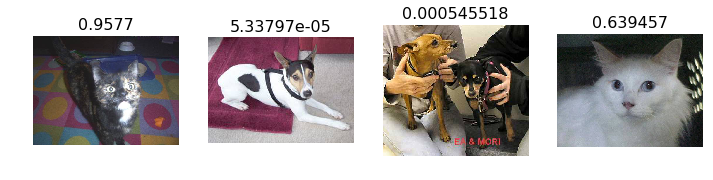

In [31]:
#1. A few correct labels at random
correct = np.where(preds == val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

(7,)


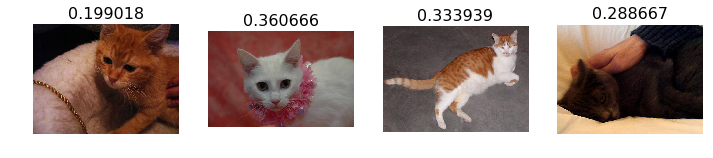

In [32]:
#2. A few incorrect labels at random
incorrect = np.where(preds != val_labels[:,1])[0]
print(incorrect.shape)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

In [33]:
preds

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

In [34]:
val_labels[:,1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

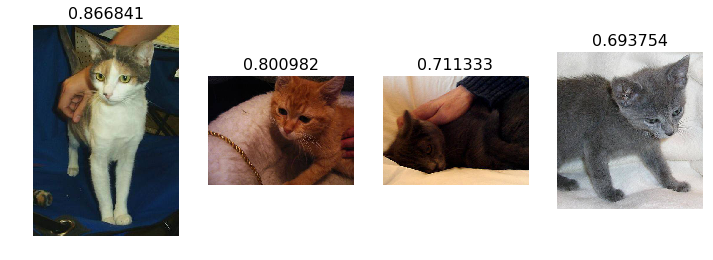

In [35]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds == 1) & (preds != val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1 - probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

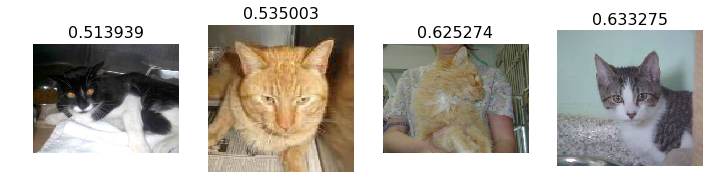

In [36]:
#5. The most uncertain labels (i.e. those with probability close to 0.5)
most_uncertain = np.argsort(np.abs(probs - 0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a confusion matrix. Scikit-learn has a convenient function we can use for this purpose:

In [37]:
cm = confusion_matrix(val_classes, preds)

We can just print out the confusion matrix, or we can show a graphocal view( which is mainlt useful for dependents with a larger number of categories).

[[21  6]
 [ 1 22]]


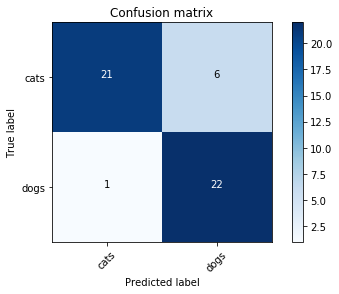

In [38]:
plot_confusion_matrix(cm, val_batches.class_indices)

### About activation functions

Do you remember how we defined out linear model? Here it is again for reference:

```
lm = Sequential([Dense(2, activarion = 'softmax', input_shape = (1000,))]
```

And do you remember the definition of a fully connected layer in the original VGG?:

```
model.add(Dense(4096, activation = 'relu'))
```

You might we wondering, what's going on with that _activation_ parameter? Adding an 'activation' parameter to a layer in Keras causes an additional function called after the layer is calculated. You'll recall that we had no such parameter in out most basic linear model at the start of this lesson - that's because of the linear model has not _activation function_. But nearly all deep model layers hace an activation function - specifically, a _non-linear_ activation function, such as `tanh`, `sigmoid (1/(1+exp(x))`, or `relu (max(0,x))`, called the _rectified linear function_. Why?

The reason for this is that if you stack purely linear layers on top of each other, thenm you just end up with a linear layer! For instance, if you first layer ws `2*x`, and your second was `-2*x`, then the combination is: `-2*(2*x)` = `-4*x`. If that's all we were able to do with deep learning, it wouldn't be very deep!. But what if we added a relu activation after our first layer? Then the combination would be: `-2 * max(0, 2*x)`. As you can see, that does not simplify to just a linear function like the previous example -- and indeed we can stack as many of these on top of each other as we wish, to create arbitararily complex functions.

Asn why would we wnt to do that? Because it turns out that such a stack of linear functions and non-linera activations can approximate any other function just as close as we want. So we cna *use it io model anything*! This extraordinary insight is known as the _universal approximation theorem_. For a visual understanding of how and why this works, I strongly recommend you read Michael Nielsen's excelent interactive visual tutorial.

The last layer generally needs a different activation function to the other layers -- because we want to encourage the last layer's output to be of an appropriate form for out partivvular problem. For instance, if our output is a one hot-encoded categorical variable, we wnat out final layer's activations to add to one (sop they can be treated as probabilities) and to have generally a single vactivation much higher than the rest (since with one hot encoding we have just a single 'one', and all ohter target outputs are zero). Out classication problems will always have this form, so we will intorduce the activation function that has these properties: the `softmax` function. SOfrmax is defined as (for the i'th otput activation): `exp(x[i])/sum(exp(x))`

I suggest you try playing tha tfunction in s aspreadsheet to get a sense of how it behaves.

We will see other activation functions later in this course -- but `relu` (and minor variations) for intermediate layers and sogtmax for output layers will be by far the most common.

## Modifying the model

### Retrain last layer's linear model

Since the original VGG16 network's last layer is `Dense` (i.e. a linear model) it seems a little odd that we are adding an additional linear model on top of it. This is especially true since that last layer had a softmax activation, which is an odd choice for an intermediate layer -- and by adding an extra layer on top of it, we have made it an intermediate layer. What if we just removed the original final layer and replaced it with one that we train for the purpose of distinguishing cats and dogs? It turn otu that this is a good idea -- as we'll see!

We start by removing the last layer, and telling Keras taht we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [39]:
vgg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [40]:
outputLayer = model.pop()
for layer in model.layers: layer.trainable = False

In [42]:
print(outputLayer)

None


**Careful!** Now that we've modified the definition of `model`, be careful not to rerun any code in the previous sections, without first recreating the model from scratch! (Yes, I made that mistake myself, which is why I'm warning you about it now...)

Now, we're ready to add out new final layer...

In [43]:
model.add(Dense(2, activation = 'softmax'))

In [44]:
??vgg.finetune

... and compile out updated model, and set up our batches to use the preprocessed images (note taht new we will also _shuffle_ the training batches, to add more randomness when using multiple epochs):

In [45]:
gen = image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size = batch_size, shuffle = True)
val_batches = gen.flow(val_data, val_labels, batch_size = batch_size, shuffle = False)

We'll define a simple function for fitting models, just to save a little typing...

In [55]:
def fit_model(model, batches, val_batches, epochs = 1):
    model.fit_generator(batches,
                        steps_per_epoch = batches.n,
                        epochs = epochs,
                        validation_data = val_batches,
                        validation_steps = val_batches.n)

In [56]:
opt = RMSprop(lr = 0.1)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [57]:
fit_model(model, batches, val_batches, epochs = 2)

Epoch 1/2
200/200 [==============================] - 2506s - loss: 7.2024 - acc: 0.5500 - val_loss: 8.9730 - val_acc: 0.4433
Epoch 2/2
200/200 [==============================] - 2468s - loss: 6.7916 - acc: 0.5763 - val_loss: 5.4566 - val_acc: 0.6615


Before moving on, go back and look at how little code we had to write in this section to finetune the model. Because this si such an important and common operation, keras is set up to make it as easy as possible. We didn't event have to use any external helper functions in this section.

It's a good idea to save weights of all your models, so you can re-use them later. Be sure to note the git log number of your model when keeping a research journal of your results.

In [58]:
model.save_weights(model_path + 'finetune1.h5')

In [59]:
model.load_weights(model_path + 'finetune1.h5')

In [60]:
model.evaluate(val_data, val_labels)

50/50 [==============================] - 118s    


[5.4801526641845699, 0.66000000059604647]

We can look at the earlier prediction examples visualizations by redefining `probs` and `preds` and re-using our earlier code.

In [61]:
preds = model.predict_classes(val_data, batch_size = batch_size)
probs = model.predict_proba(val_data, batch_size = batch_size)[:,0]
probs[:8]

50/50 [==============================] - 125s   


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [62]:
cm = confusion_matrix(val_classes, preds)

[[27  0]
 [17  6]]


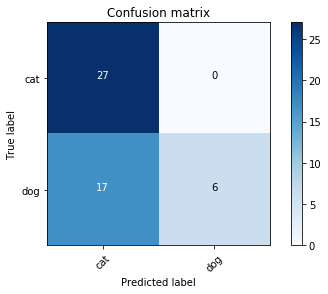

In [63]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Retraining more layers

Now that we've fine-tuned the new final layer, can we, and should we, find-tune _all_ the dense layers? The anwer to both questions, it turns out, is: yes! Let's start with the "can we" question...

### An introduction to back-propagation

The key to training multiple layers of a model, rather than just one, lies in a technique called "back-propagation" (or _backprop_ to its friends). Backprop is one of the many words indeep learning parlance that is creating a new word for something that already exists - in this case, backprop simply refers to calculating gradients using the _chain rule_. (But we will still intorduce the deep learning terms during this course, since it's important to know them when reading about ot discussion deep learning.)

As you (hopefully~) remember from high school, the chain rule is how you calculate the gradient of a "function of a function" -- something of the form `f(u)`, where `u = g(x)`. For instance, let's say your function is `pow((2*x), 2)`. Then `u` is `2*x`, and `f(u)` is `power(u, 2)`. The chain rule tells us that the derivative of this is simply the product of the derivatives of `f()` and `g()`. Using `f'(x)` to refer to the derivative, we can say that: `f'(x) = f'(u)*g'(x) = 2*u * 2 = 2*(2*x) * 2 = 8*x`.

Let's check our calculation:


In [64]:
# sympy let's us do symbolic differentiation (and much more!) in python
import sympy as sp
# We have to define our variables
x = sp.var('x')
# then we can request the derivative or ay expression of that variable
pow(2*x,2).diff()

8*x

The key insight is that the stacking of linear functions and non-linear activations we learnt about in the last section is simply defining a function of functions (of function, of functions...). Each layer is taking the output of the previous layer's function, and using it as input into its function. Therefore, we can calculate the derivative aat any layer by simply multiplying the gradients of that layer and all of its following layers together! This use of the chain rule to allow us to rapidly calculate the deivatibes of out model at any layer is referred to as _backpropagation_.

The good news is taht you'll never have to worry about the details of this yourself, since libraries like Theano and Tensorflow (and therefore warppers like Keras) provide _automatic differentiation_ (or AD). **TODO**

### Training multiple layers in Keras

The code below will work on any model that contains dense layers; it's not just for this VGG model.

NB: Don't skip the step of fine-tuning jus the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly mode a long way from their otimized imagener weights.

In [67]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index, layer in enumerate(layers) if type(layer) is Dense][0]
# ... and set this and all sebsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable = True

Since we haven't changed out architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.

In [ ]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
200/200 [==============================] - 2578s - loss: 5.8356 - acc: 0.6325 - val_loss: 2.0779 - val_acc: 0.8542
Epoch 2/3
200/200 [==============================] - 2168s - loss: 2.0650 - acc: 0.8600 - val_loss: 1.6790 - val_acc: 0.8958
Epoch 3/3
 79/200 [==========>...................] - ETA: 878s - loss: 1.6808 - acc: 0.8797

This is an extraordinarily powerful 5 lines of code. We have find-tuned all of our dense layers to be optimized for out specific data set. This kind of technique has only become accessible in the last year or two - and we can already do it in just 5 lines of python~


In [ ]:
model.save_weights(model_path + 'finetune2.h5')

There's generally little room for improvement in training the convolutional layers, i fyou're using the model on natural images(as we are). However, there's no harm trying a few of the later conv layers, since it may give a slight improvement, and can't hurt (and we can always load the precious weights if the accuracy decreases).

In [ ]:
for layer in layers[12:]: layer.trainable = True
K.set_value(opt.lr, 0.001)

In [ ]:
fit_model(model, batches, val_batches, 4)

In [ ]:
model.save_weights(model_path + 'finetune3.h5')

You can always load the weights later and use the model to do whatever you need:

In [ ]:
model.load_weights(model_path + 'finetune2.h5')
model.evaluate_generator(get_batches(path + 'valid', ge, False, batch_size * 2), val_batches.n)